In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Adversarial Image Attack Visualization Utils

In [ ]:

import torch
import matplotlib.pyplot as plt
import os

# Mean and std for ImageNet
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])


In [ ]:

def compute_linf_distance(orig, adv, mean, std):
    mean = mean.view(3, 1, 1)
    std = std.view(3, 1, 1)
    orig_raw = orig * std + mean
    adv_raw = adv * std + mean
    diff = (orig_raw - adv_raw).abs()
    return diff.max().item()


In [ ]:

def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (tensor * std + mean).clamp(0, 1)

def visualize_attack_grid(samples, title, epsilon, save_path="figures/grid.png", draw=True):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig, axes = plt.subplots(2, len(samples), figsize=(2*len(samples), 4))

    for i, (orig, adv, true_label, pred_label, linf) in enumerate(samples):
        orig_img = unnormalize(orig).permute(1, 2, 0).cpu().numpy()
        adv_img = unnormalize(adv).permute(1, 2, 0).cpu().numpy()

        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f"Original: {true_label}", fontsize=10)
        axes[0, i].axis('off')

        axes[1, i].imshow(adv_img)
        axes[1, i].set_title(f"Adversarial: {pred_label}\n$L_\infty$ dist: {linf:.6f}", fontsize=10)
        axes[1, i].axis('off')

    plt.suptitle(f"{title} (ε = {epsilon})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.savefig(save_path)
    if draw: plt.show()


In [ ]:
!ls

combined_attack_grid.png  drive  sample_data


In [ ]:
DATASET_FOLDER = "/content/drive/MyDrive/TestDataSet"
LABELS_JSON    = "/content/drive/MyDrive/TestDataSet/labels_list.json"

In [ ]:
resnet_results = {}
traning_time_results = {}
training_time = []
inference_time = []
import json
import urllib.request

# Download the official ImageNet 1K class label index used by PyTorch
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode().splitlines()

# Task 1 – Baseline accuracy on the provided test split


In [ ]:
import os
import json
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# -------------------------------
# STEP 1: Device setup
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# STEP 2: Load model
# -------------------------------
model = torchvision.models.resnet34(weights="IMAGENET1K_V1")
model.eval()
model.to(device)

# -------------------------------
# STEP 3: Load and normalize data
# -------------------------------
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms  = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset = torchvision.datasets.ImageFolder(root=DATASET_FOLDER, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# -------------------------------
# STEP 4: Parse labels JSON
# -------------------------------
with open(LABELS_JSON, "r") as f:
    raw = json.load(f)

# Build:
# - dataset label idx (0–99) → ImageNet idx (401–500)
# - ImageNet idx → class_name
# - ImageNet idx → new class ID (1–100)
imagenet_indices = []
name_map = {}
id_map = {}

for i, entry in enumerate(raw):
    idx_str, class_name = entry.split(":", 1)
    imagenet_id = int(idx_str.strip())         # 401 → 500
    imagenet_indices.append(imagenet_id)       # ordered list
    name_map[imagenet_id] = class_name.strip() # 401 → "accordion"
    id_map[imagenet_id] = i + 1                # 401 → 1, 402 → 2, ..., 500 → 100

# dataset label → ImageNet index (401–500)
label_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

# -------------------------------
# STEP 5: Evaluate accuracy (no skipping)
# -------------------------------
top1, top5, total = 0, 0, 0
printed = 0
print_limit = 5

import time

start = time.time()
infer = 0
with torch.no_grad():
    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)
        sstart = time.time()
        outputs = model(images)
        infer += time.time() - sstart
        preds = outputs.topk(5, dim=1).indices  # shape: [batch_size, 5]

        for i in range(images.size(0)):
            dataset_label = labels[i].item()             # 0–99
            true_imagenet = label_map[dataset_label]     # e.g. 401
            true_class_id = id_map[true_imagenet]        # e.g. 1–100

            top5_global = preds[i].tolist()

            # Map ANY of those into your 1–100 classes
            top5_class_ids = [id_map[g] for g in top5_global if g in id_map]

            # ── CORRECT Top-1 ────────────────────────────────────
            # Take the model’s rank-1 global prediction, then map it
            first_global = top5_global[0]
            top1_pred = id_map[first_global] if first_global in id_map else -1

            # Now compare
            if top1_pred == true_class_id:
                top1 += 1

            # Top-5 remains: did the true label appear anywhere in your mapped list?
            if true_class_id in top5_class_ids:
                top5 += 1

            total += 1

            if printed < print_limit:
                pred_name = name_map.get(top5_global[0], '[Unknown]')
                top5_names = [name_map.get(p, f"[{p}]") for p in top5_global]
                print(f"Example {printed+1}: GT={true_class_id:3d} ({name_map[true_imagenet]}) | "
                      f"Pred={top1_pred:3d} ({pred_name}) | Top5={top5_class_ids}")
                printed += 1

print(f"Total inference time: {infer:.2f} seconds")
inference_time.append(infer)
training_time.append(0)
# -------------------------------
# STEP 6: Final results
# -------------------------------
print(f"\n Evaluated {total} images")
print(f"Top-1 Accuracy: {top1 / total * 100:.2f}%")
print(f"Top-5 Accuracy: {top5 / total * 100:.2f}%")

resnet_results['Clean'] = (top1 / total * 100, top5 / total * 100)
traning_time_results['Clean'] = 0


Using device: cuda


 12%|█▎        | 2/16 [00:00<00:02,  5.36it/s]

Example 1: GT=  1 (accordion) | Pred=  1 (accordion) | Top5=[1]
Example 2: GT=  1 (accordion) | Pred=  1 (accordion) | Top5=[1]
Example 3: GT=  1 (accordion) | Pred= -1 ([Unknown]) | Top5=[1]
Example 4: GT=  1 (accordion) | Pred=  1 (accordion) | Top5=[1]
Example 5: GT=  1 (accordion) | Pred= -1 ([Unknown]) | Top5=[]


100%|██████████| 16/16 [00:02<00:00,  5.77it/s]

Total inference time: 0.10 seconds

 Evaluated 500 images
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2 – Single‑step FGSM $L_\infty$ attack


=== Task 2: FGSM Attack ===
PGD attack took 9.28 seconds total
PGD infer took 2.73 seconds total

 Saved 500 adversarial images to /content/drive/MyDrive/AdversarialTestSet1


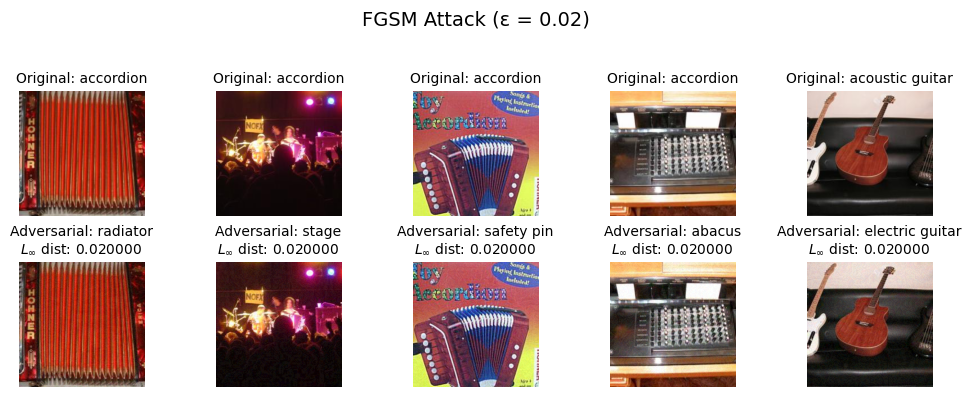

Max L∞ raw distance: 0.020000025629997253

 FGSM Adversarial Top-1 Accuracy: 3.60%
 FGSM Adversarial Top-5 Accuracy: 21.40%


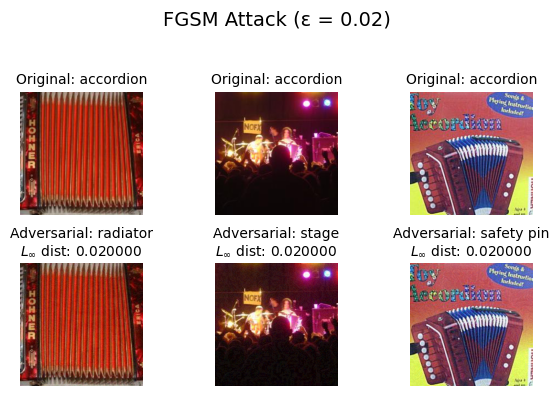

In [ ]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

# ---------------------------
# Setup and config
# ---------------------------
epsilon = 0.02  # attack budget in raw pixel space
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_norms  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
mean_t = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
std_t  = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)
lower = (0 - mean_t) / std_t
upper = (1 - mean_t) / std_t
eps_norm = torch.tensor((epsilon / std_norms).reshape(1,3,1,1), dtype=torch.float32).to(device)
infer = 0
train = 0
# ---------------------------
# Load pretrained model
# ---------------------------
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# ---------------------------
# Load dataset
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
dataset_path = DATASET_FOLDER
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load label map (0-99 → ImageNet idx)
with open(LABELS_JSON) as f:
    label_list = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in label_list]
label_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

# ---------------------------
# FGSM attack
# ---------------------------
successful = []
adv_images = []
adv_labels = []
orig_images = []

import time

start_time = time.time()


print("\n=== Task 2: FGSM Attack ===")
for i, (img, target) in enumerate(dataset):
    img_tensor = img.unsqueeze(0).to(device).float()
    orig_images.append(img_tensor.detach().cpu())

    true_label = torch.tensor([label_map[target]]).to(device)

    img_tensor.requires_grad = True
    output = model(img_tensor)
    loss = F.cross_entropy(output, true_label)
    model.zero_grad()
    loss.backward()

    grad_sign = img_tensor.grad.data.sign()
    perturbed = img_tensor + eps_norm * grad_sign
    perturbed = torch.max(torch.min(perturbed, upper), lower).detach()
    stime = time.time()
    with torch.no_grad():
        pred = model(perturbed).argmax(1).item()
    infer += time.time() - stime

    if pred != true_label.item() and len(successful) < 5:
        successful.append((
            img_tensor.squeeze(0).detach().cpu(),
            perturbed.squeeze(0).cpu(),
            true_label.item(),
            pred
        ))

    adv_images.append(perturbed.cpu().squeeze(0))
    adv_labels.append(target)

train = time.time() - start_time - infer
# print(f"PGD attack took {elapsed_time:.2f} seconds total")
training_time.append(train)
inference_time.append(infer)
print(f"PGD attack took {train:.2f} seconds total")
print(f"PGD infer took {infer:.2f} seconds total")

# ---------------------------
# Save adversarial dataset
# ---------------------------
adv_dir = '/content/drive/MyDrive/AdversarialTestSet1'
os.makedirs(adv_dir, exist_ok=True)
for class_name in dataset.classes:
    os.makedirs(os.path.join(adv_dir, class_name), exist_ok=True)

for i, (img, target) in enumerate(zip(adv_images, adv_labels)):
    subdir = dataset.classes[target]
    path = os.path.join(adv_dir, subdir, f"adv_{i:04d}.png")
    denorm = img * torch.tensor(std_norms).view(3,1,1) + torch.tensor(mean_norms).view(3,1,1)
    save_image(denorm, path)

print(f"\n Saved 500 adversarial images to {adv_dir}")

# ---------------------------
# Visualize 3–5 successful attacks
# ---------------------------
samples = []
for (orig, adv, true, pred) in successful[:5]:
    linf = compute_linf_distance(orig, adv, mean, std)
    samples.append((orig, adv, imagenet_classes[true], imagenet_classes[pred], linf))

visualize_attack_grid(samples, title="FGSM Attack", epsilon=0.02, save_path="/content/drive/MyDrive/task2_fgsm_grid.png")
visualize_attack_grid(samples[:3], title="FGSM Attack", epsilon=0.02, save_path="/content/drive/MyDrive/task2_fgsm_grid_1.png", draw=False)

# ---------------------------
# Verify L∞ distance constraint
# ---------------------------
orig = torch.cat(orig_images)
adv  = torch.stack(adv_images)
diff = (orig - adv) * std_t.cpu()
linf = diff.abs().view(diff.size(0), -1).max(1)[0]
print("Max L∞ raw distance:", linf.max().item())
assert linf.max().item() <= epsilon + 1e-6

# ---------------------------
# Evaluate top-1 and top-5 on adversarial set
# ---------------------------
adv_dataset = datasets.ImageFolder(root=adv_dir, transform=transform)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
adv_class_to_idx = adv_dataset.class_to_idx
adv_label_map = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(adv_class_to_idx.items()))}

top1 = top5 = total = 0
with torch.no_grad():
    for imgs, lbls in adv_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        preds = outputs.topk(5, dim=1).indices
        for i in range(imgs.size(0)):
            true = adv_label_map[lbls[i].item()]
            top5_preds = preds[i].tolist()
            top1_pred = top5_preds[0]
            if top1_pred == true:
                top1 += 1
            if true in top5_preds:
                top5 += 1
            total += 1

print(f"\n FGSM Adversarial Top-1 Accuracy: {top1 / total * 100:.2f}%")
print(f" FGSM Adversarial Top-5 Accuracy: {top5 / total * 100:.2f}%")
resnet_results['FGSM'] = (top1 / total * 100, top5 / total * 100)
traning_time_results['FGSM'] = train




# Task 3 – Stronger multi‑step $L_\infty$ attacks


=== Task 3: PGD Attack ===


100%|██████████| 500/500 [01:17<00:00,  6.45it/s]


PGD attack took 74.62 seconds total
PGD infer took 2.90 seconds total

 Saved 500 PGD adversarial images to /content/drive/MyDrive/AdversarialTestSet2


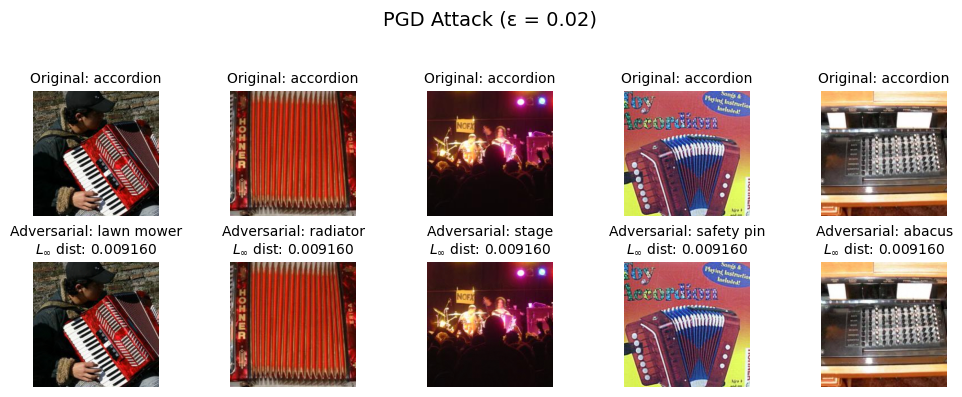

Max L∞ raw distance (PGD): 0.009160018526017666

 PGD Adversarial Top-1 Accuracy: 0.00%
 PGD Adversarial Top-5 Accuracy: 6.80%


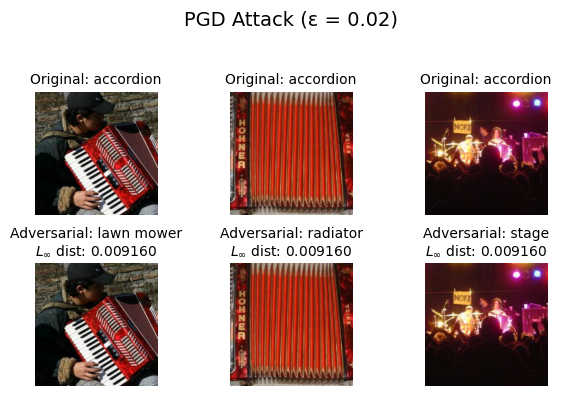

In [ ]:
# ---------------------------
# Task 3: Improved PGD Attack
# ---------------------------
print("\n=== Task 3: PGD Attack ===")

def pgd_attack(img, label, model, eps_norm, lower, upper, steps=10, alpha=0.004):
    adv = img.clone().detach().to(device)
    for _ in range(steps):
        adv.requires_grad = True
        output = model(adv)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        grad = adv.grad.detach()
        adv = adv + alpha * grad.sign()
        adv = torch.max(torch.min(adv, img + eps_norm), img - eps_norm)
        adv = torch.max(torch.min(adv, upper), lower).detach()
    return adv

successful = []
adv_images = []
adv_labels = []
orig_images = []
infer = 0
import time

start_time = time.time()


for i, (img, target) in enumerate(tqdm(dataset)):
    img_tensor = img.unsqueeze(0).to(device).float()
    orig_images.append(img_tensor.detach().cpu())

    true_label = torch.tensor([label_map[target]]).to(device)
    adv = pgd_attack(img_tensor, true_label, model, eps_norm, lower, upper, steps=10, alpha=0.004)
    stime = time.time()
    with torch.no_grad():
        pred = model(adv).argmax(1).item()
    infer += time.time() - stime

    if pred != true_label.item() and len(successful) < 5:
        successful.append((
            img_tensor.squeeze(0).cpu(),
            adv.squeeze(0).cpu(),
            true_label.item(),
            pred
        ))

    adv_images.append(adv.cpu().squeeze(0))
    adv_labels.append(target)

train = time.time() - start_time - infer
print(f"PGD attack took {train:.2f} seconds total")
print(f"PGD infer took {infer:.2f} seconds total")
training_time.append(train)
inference_time.append(infer)

# ---------------------------
# Save Adversarial Test Set 2
# ---------------------------
adv_dir = '/content/drive/MyDrive/AdversarialTestSet2'
os.makedirs(adv_dir, exist_ok=True)
for class_name in dataset.classes:
    os.makedirs(os.path.join(adv_dir, class_name), exist_ok=True)

for i, (img, target) in enumerate(zip(adv_images, adv_labels)):
    subdir = dataset.classes[target]
    path = os.path.join(adv_dir, subdir, f"adv_{i:04d}.png")
    denorm = img * torch.tensor(std_norms).view(3,1,1) + torch.tensor(mean_norms).view(3,1,1)
    save_image(denorm, path)

print(f"\n Saved 500 PGD adversarial images to {adv_dir}")

# ---------------------------
# Visualize 3–5 successful PGD attacks
# ---------------------------
samples = []
for (orig, adv, true, pred) in successful[:5]:
    linf = compute_linf_distance(orig, adv, mean, std)
    samples.append((orig, adv, imagenet_classes[true], imagenet_classes[pred], linf))

visualize_attack_grid(samples, title="PGD Attack", epsilon=0.02, save_path="/content/drive/MyDrive/task3_pgd_grid.png")
visualize_attack_grid(samples[:3], title="PGD Attack", epsilon=0.02, save_path="/content/drive/MyDrive/task3_pgd_grid_1.png", draw=False)

# ---------------------------
# Verify L∞ distance ≤ 0.02
# ---------------------------
orig = torch.cat(orig_images)
adv  = torch.stack(adv_images)
diff = (orig - adv) * std_t.cpu()
linf = diff.abs().view(diff.size(0), -1).max(1)[0]
print("Max L∞ raw distance (PGD):", linf.max().item())
assert linf.max().item() <= epsilon + 1e-6

# ---------------------------
# Evaluate ResNet-34 on Adversarial Test Set 2
# ---------------------------
adv_dataset = datasets.ImageFolder(root=adv_dir, transform=transform)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
adv_class_to_idx = adv_dataset.class_to_idx
adv_label_map = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(adv_class_to_idx.items()))}

top1 = top5 = total = 0
with torch.no_grad():
    for imgs, lbls in adv_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        preds = outputs.topk(5, dim=1).indices
        for i in range(imgs.size(0)):
            true = adv_label_map[lbls[i].item()]
            top5_preds = preds[i].tolist()
            if top5_preds[0] == true:
                top1 += 1
            if true in top5_preds:
                top5 += 1
            total += 1

print(f"\n PGD Adversarial Top-1 Accuracy: {top1 / total * 100:.2f}%")
print(f" PGD Adversarial Top-5 Accuracy: {top5 / total * 100:.2f}%")
resnet_results['PGD'] = (top1 / total * 100, top5 / total * 100)
traning_time_results['PGD'] = train


# Task 4 – Patch‑based attacks


=== Task 4: Targeted Patch Attack → Target = 'baseball' (idx=429) ===


100%|██████████| 500/500 [07:06<00:00,  1.17it/s]


Targeted Patch Attack took 423.31 seconds total
Targeted Patch Attack infer took 2.81 seconds total

 Saved 500 targeted patch adversarial images to /content/drive/MyDrive/AdversarialTestSet3


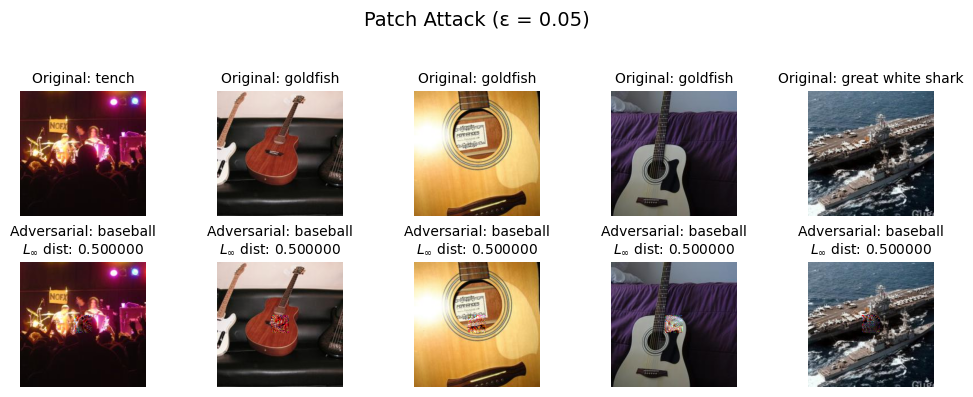


 Targeted Patch Attack Top-1 Accuracy: 20.00%
 Targeted Patch Attack Top-5 Accuracy: 50.20%
 Images misclassified as 'baseball': 332 / 500 (66.40%)


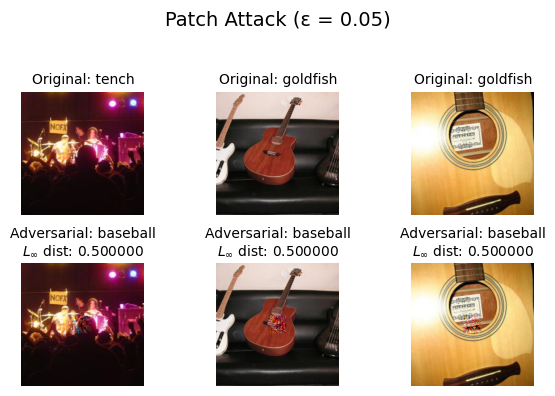

In [ ]:
import os
import json
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

# ---------------------------
# Setup
# ---------------------------
epsilon_patch = 0.5
alpha_patch = 0.1
patch_size = 32
steps = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_norms  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
mean_t = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
std_t  = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)
lower = (0 - mean_t) / std_t
upper = (1 - mean_t) / std_t
eps_patch_norm = torch.tensor((epsilon_patch / std_norms).reshape(1,3,1,1), dtype=torch.float32).to(device)

# ---------------------------
# Load model
# ---------------------------
model = models.resnet34(weights='IMAGENET1K_V1').to(device)
model.eval()

# ---------------------------
# Load dataset
# ---------------------------
DATASET_FOLDER = '/content/drive/MyDrive/TestDataSet'
LABELS_JSON = '/content/drive/MyDrive/TestDataSet/labels_list.json'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])
dataset = datasets.ImageFolder(root=DATASET_FOLDER, transform=transform)

with open(LABELS_JSON) as f:
    label_list = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in label_list]
label_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

# ---------------------------
# Find ImageNet index for "baseball"
# ---------------------------
target_class_str = "baseball"  # Picked from your list

try:
    target_imagenet_idx = next(
        int(x.split(":")[0]) for x in label_list if target_class_str.lower() in x.lower()
    )
except StopIteration:
    print(f" Target class '{target_class_str}' not found in label_list.")
    for x in label_list: print("-", x)
    raise

# ---------------------------
# Targeted PGD Patch Attack
# ---------------------------
def pgd_patch_attack_targeted(img, model, target_idx, eps_norm, lower, upper, patch_size=32, alpha=0.05, steps=10):
    adv = img.clone().detach().to(device)
    B, C, H, W = adv.shape
    # top = random.randint(0, H - patch_size)
    # left = random.randint(0, W - patch_size)
    top = (H - patch_size) // 2
    left = (W - patch_size) // 2

    target_label = torch.tensor([target_idx]).to(device)

    for _ in range(steps):
        adv.requires_grad = True
        out = model(adv)
        loss = -F.cross_entropy(out, target_label)  # Targeted
        model.zero_grad()
        loss.backward()
        grad = adv.grad.detach()
        patch_grad = grad[:,:,top:top+patch_size, left:left+patch_size].sign()
        patch = adv[:,:,top:top+patch_size, left:left+patch_size] + alpha * patch_grad
        adv = adv.clone()
        adv[:,:,top:top+patch_size, left:left+patch_size] = patch
        adv = torch.max(torch.min(adv, img + eps_norm), img - eps_norm)
        adv = torch.clamp(adv, min=lower, max=upper).detach()
    return adv

# ---------------------------
# Generate Adversarial Test Set 3
# ---------------------------
print(f"\n=== Task 4: Targeted Patch Attack → Target = '{target_class_str}' (idx={target_imagenet_idx}) ===")
successful = []
adv_images = []
adv_labels = []
orig_images = []
baseball_count = 0

import time

start_time = time.time()
infer = 0

for i, (img, target) in enumerate(tqdm(dataset)):
    img_tensor = img.unsqueeze(0).to(device).float()
    orig_images.append(img_tensor.detach().cpu())

        adv = pgd_patch_attack_targeted(
        img_tensor, model, target_imagenet_idx,
        eps_patch_norm, lower, upper,
        patch_size=patch_size, alpha=alpha_patch, steps=steps
    )
    stime = time.time()
    with torch.no_grad():
        pred = model(adv).argmax(1).item()
    infer += time.time() - stime
    if pred == target_imagenet_idx:
        baseball_count += 1
        if len(successful) < 5:
            successful.append((img_tensor.squeeze(0).cpu(), adv.squeeze(0).cpu(), target, pred))

    adv_images.append(adv.squeeze(0).cpu())
    adv_labels.append(target)

train = time.time() - start_time - infer
print(f"Targeted Patch Attack took {train:.2f} seconds total")
print(f"Targeted Patch Attack infer took {infer:.2f} seconds total")
training_time.append(train)
inference_time.append(infer)

# ---------------------------
# Save Adversarial Set
# ---------------------------
adv_dir = '/content/drive/MyDrive/AdversarialTestSet3'
os.makedirs(adv_dir, exist_ok=True)
for class_name in dataset.classes:
    os.makedirs(os.path.join(adv_dir, class_name), exist_ok=True)

for i, (img, target) in enumerate(zip(adv_images, adv_labels)):
    subdir = dataset.classes[target]
    path = os.path.join(adv_dir, subdir, f"adv_{i:04d}.png")
    denorm = img * torch.tensor(std_norms).view(3,1,1) + torch.tensor(mean_norms).view(3,1,1)
    save_image(denorm, path)

print(f"\n Saved 500 targeted patch adversarial images to {adv_dir}")

# ---------------------------
# Visualize 3–5 successful
# ---------------------------
samples = []
for (orig, adv, true, pred) in successful[:5]:
    linf = compute_linf_distance(orig, adv, mean, std)
    samples.append((orig, adv, imagenet_classes[true], imagenet_classes[pred], linf))

visualize_attack_grid(samples, title="Patch Attack", epsilon=0.05, save_path="/content/drive/MyDrive/task4_patch_grid.png")
visualize_attack_grid(samples[:3], title="Patch Attack", epsilon=0.05, save_path="/content/drive/MyDrive/task4_patch_grid_1.png", draw=False)

# ---------------------------
# Evaluation
# ---------------------------
adv_dataset = datasets.ImageFolder(root=adv_dir, transform=transform)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
adv_class_to_idx = adv_dataset.class_to_idx
adv_label_map = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(adv_class_to_idx.items()))}

top1 = top5 = total = 0
with torch.no_grad():
    for imgs, lbls in adv_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        preds = outputs.topk(5, dim=1).indices
        for i in range(imgs.size(0)):
            true = adv_label_map[lbls[i].item()]
            top5_preds = preds[i].tolist()
            if top5_preds[0] == true:
                top1 += 1
            if true in top5_preds:
                top5 += 1
            total += 1

print(f"\n Targeted Patch Attack Top-1 Accuracy: {top1 / total * 100:.2f}%")
print(f" Targeted Patch Attack Top-5 Accuracy: {top5 / total * 100:.2f}%")
print(f" Images misclassified as 'baseball': {baseball_count} / 500 ({baseball_count / 500 * 100:.2f}%)")
resnet_results['Patch'] = (top1 / total * 100, top5 / total * 100)
traning_time_results['Patch'] = train


# Task 5 – Transferability study

In [ ]:
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

# ---------------------------
# Load alternative model
# ---------------------------
model_name = "densenet121"
model = models.densenet121(weights='IMAGENET1K_V1').to(device)
model.eval()

# ---------------------------
# Preprocessing (same as before)
# ---------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# ---------------------------
# Evaluation function
# ---------------------------
def evaluate_dataset(folder_path, name):
    dataset = datasets.ImageFolder(root=folder_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    class_to_idx = dataset.class_to_idx
    label_map_eval = {v: imagenet_indices[i] for i, (k, v) in enumerate(sorted(class_to_idx.items()))}
    infer = 0
    top1 = top5 = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            stime = time.time()
            outputs = model(imgs)
            infer += time.time() - stime
            preds = outputs.topk(5, dim=1).indices
            for i in range(imgs.size(0)):
                true = label_map_eval[lbls[i].item()]
                top_preds = preds[i].tolist()
                if top_preds[0] == true:
                    top1 += 1
                if true in top_preds:
                    top5 += 1
                total += 1
    top1_acc = top1 / total * 100
    top5_acc = top5 / total * 100
    print(f" {name} — Top-1: {top1_acc:.2f}% | Top-5: {top5_acc:.2f}%")
    # print infer time
    print(f" {name} — Infer time: {infer:.2f} seconds")
    training_time.append(0)
    inference_time.append(infer)
    return top1_acc, top5_acc

# ---------------------------
# Run on all 4 datasets
# ---------------------------
densenet_results = {}
densenet_results["Clean"] = evaluate_dataset("/content/drive/MyDrive/TestDataSet", "Clean Test Set")
densenet_results["FGSM"] = evaluate_dataset("/content/drive/MyDrive/AdversarialTestSet1", "Adversarial Set 1 (FGSM)")
densenet_results["PGD"] = evaluate_dataset("/content/drive/MyDrive/AdversarialTestSet2", "Adversarial Set 2 (PGD)")
densenet_results["Patch"] = evaluate_dataset("/content/drive/MyDrive/AdversarialTestSet3", "Adversarial Set 3 (Patch)")


 Clean Test Set — Top-1: 74.80% | Top-5: 93.60%
 Clean Test Set — Infer time: 0.33 seconds
 Adversarial Set 1 (FGSM) — Top-1: 46.00% | Top-5: 76.20%
 Adversarial Set 1 (FGSM) — Infer time: 0.42 seconds
 Adversarial Set 2 (PGD) — Top-1: 61.80% | Top-5: 89.20%
 Adversarial Set 2 (PGD) — Infer time: 0.32 seconds
 Adversarial Set 3 (Patch) — Top-1: 70.20% | Top-5: 91.40%
 Adversarial Set 3 (Patch) — Infer time: 0.31 seconds


# Show the accuracy and attck time in table

In [ ]:
from tabulate import tabulate

# Assuming resnet_results, densenet_results, and traning_time_results are defined

# Prepare table data
table_data = []
for key in resnet_results:
    resnet_top1, resnet_top5 = resnet_results[key]
    dnet_top1, dnet_top5 = densenet_results[key]
    training_time = traning_time_results[key]
    row = [
        key,
        f"{resnet_top1:.2f} / {resnet_top5:.2f}",
        f"{dnet_top1:.2f} / {dnet_top5:.2f}",
        f"{training_time:.2f}"
    ]
    table_data.append(row)

# Define headers
headers = ["Dataset", "ResNet-34 (Top-1 / Top-5)", "DenseNet-121 (Top-1 / Top-5)", "Training Time (s)"]

# Print grid-style table
print("\nAccuracy Comparison (Top-1 / Top-5 in %) and Training Time:\n")
print(tabulate(table_data, headers=headers, tablefmt="grid"))



Accuracy Comparison (Top-1 / Top-5 in %) and Training Time:

+-----------+-----------------------------+--------------------------------+---------------------+
| Dataset   | ResNet-34 (Top-1 / Top-5)   | DenseNet-121 (Top-1 / Top-5)   |   Training Time (s) |
+===========+=============================+================================+=====================+
| Clean     | 76.00 / 94.20               | 74.80 / 93.60                  |                0    |
+-----------+-----------------------------+--------------------------------+---------------------+
| FGSM      | 3.60 / 21.40                | 46.00 / 76.20                  |                9.28 |
+-----------+-----------------------------+--------------------------------+---------------------+
| PGD       | 0.00 / 6.80                 | 61.80 / 89.20                  |               74.62 |
+-----------+-----------------------------+--------------------------------+---------------------+
| Patch     | 20.00 / 50.20               | 70.

# Draw the accuracy plot

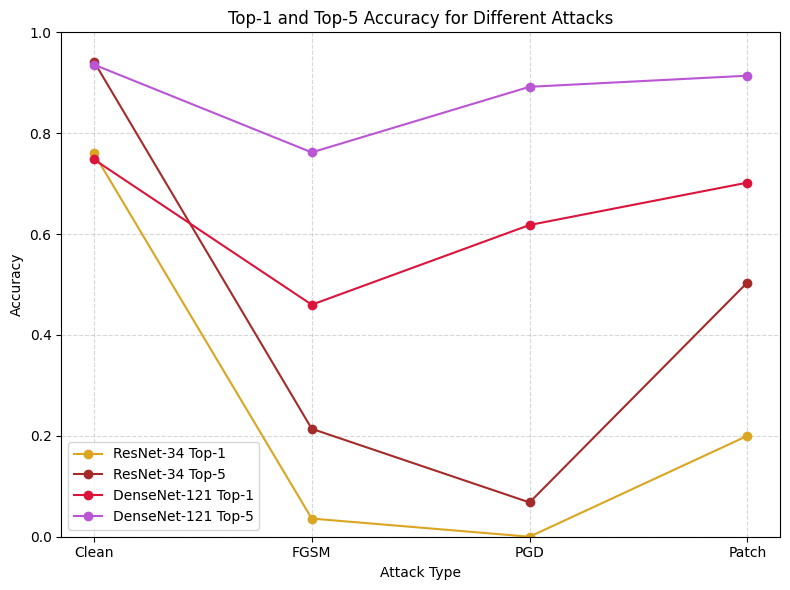

In [ ]:
import matplotlib.pyplot as plt

# Attack types
attacks = ['Clean', 'FGSM', 'PGD', 'Patch']

# Accuracy data
resnet_top1 = [0.760, 0.036, 0.000, 0.200]
resnet_top5 = [0.942, 0.214, 0.068, 0.504]
densenet_top1 = [0.748, 0.460, 0.618, 0.702]
densenet_top5 = [0.936, 0.762, 0.892, 0.914]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(attacks, resnet_top1, marker='o', color='goldenrod', label='ResNet-34 Top-1')
plt.plot(attacks, resnet_top5, marker='o', color='brown', label='ResNet-34 Top-5')
plt.plot(attacks, densenet_top1, marker='o', color='crimson', label='DenseNet-121 Top-1')
plt.plot(attacks, densenet_top5, marker='o', color='mediumorchid', label='DenseNet-121 Top-5')

# Labels and title
plt.xlabel('Attack Type')
plt.ylabel('Accuracy')
plt.title('Top-1 and Top-5 Accuracy for Different Attacks')
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_line_plot.png", dpi=300)
plt.show()


# Combine the results into one image

In [ ]:
from PIL import Image

# Load full images
fgsm_img = Image.open("/content/drive/MyDrive/task2_fgsm_grid_1.png")
pgd_img = Image.open("/content/drive/MyDrive/task3_pgd_grid_1.png")
patch_img = Image.open("/content/drive/MyDrive/task4_patch_grid_1.png")

# Determine common width
min_width = min(fgsm_img.width, pgd_img.width, patch_img.width)

# Resize all images to the same width
def resize_to_width(img, target_width):
    w_percent = target_width / img.width
    return img.resize((target_width, int(img.height * w_percent)))

fgsm_img = resize_to_width(fgsm_img, min_width)
pgd_img = resize_to_width(pgd_img, min_width)
patch_img = resize_to_width(patch_img, min_width)

# First row: FGSM + PGD
row1_height = max(fgsm_img.height, pgd_img.height)
row1 = Image.new("RGB", (min_width * 2, row1_height), (255, 255, 255))
row1.paste(fgsm_img, (0, 0))
row1.paste(pgd_img, (min_width, 0))

# Second row: PATCH centered
row2 = Image.new("RGB", (min_width * 2, patch_img.height), color=(255, 255, 255))
row2.paste(patch_img, ((min_width * 2 - patch_img.width) // 2, 0))

# Combine rows vertically
final_img = Image.new("RGB", (min_width * 2, row1_height + row2.height))
final_img.paste(row1, (0, 0))
final_img.paste(row2, (0, row1_height))

# Save the result
final_img.save("combined_grid_two_rows.png")
print("✅ Combined image saved as combined_grid_two_rows.png")


✅ Combined image saved as combined_grid_two_rows.png
